# PREDICTION

# Conditional Denoising Diffusion Probabilistic Models (DDPMs) with fastai
By Tanishq Abraham and Thomas Capelle

In this notebook, we will implement [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), a seminal paper in the diffusion model literature.

A one-sentence summary: Train a denoising model conditioned on the amount of noise present in the image, and generate samples by iteratively denoising from pure noise to a final sample conditioned to the label of the image.

The final model is capable to generate an image form a label!

Let's get started with the implementation!

## Imports

Here are all our imports. The unet file is taken from [lucidrains' DDPM implementation](https://github.com/lucidrains/denoising-diffusion-pytorch) just to focus on implementing the training process rather than architectural details.

https://docs.fast.ai/examples/migrating_pytorch_verbose.html

In [1]:
%load_ext autoreload
%autoreload 2

In [69]:
from fastai.vision.all import *
from fastai.vision.gan import *
from unet import Unet
from copy import deepcopy
from fastai.data import *
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Car Data

In [70]:
IMG_SIZE = 32 * 2 # 64
BATCH_SIZE = 4 # for training on GPU: 128 * 2; reduced for prediction of some images
PATH = "/fp/homes01/u01/ec-felixek/pc/Documents/code/data/Dataset"

In [104]:
def load_dataset():
    types = ['*.jpg', '*.npy']
    images, labels = [], []
    for data_type in types:
        for file in glob.glob(f"{PATH}/{data_type}"):
            if data_type == '*.jpg':
                image = Image.open(file)
                image = image.resize((IMG_SIZE, IMG_SIZE))
                image = np.array(image, dtype=np.uint8)
                image = image if len(image.shape) == 3 else np.dstack([image] * 3)
                images.append(image)
            if data_type == '*.npy':
                label = np.load(file)
                labels.append(label)
    
    if not images or not labels:
        raise Exception("No data loaded!")
       
    labels = np.array(labels)[:, :, 1].squeeze()  # only keep label of Moira
    
    # FIXME REMOVE - reduces processing time as val set is decreased for learner.get_preds()
    images = images[-100:]
    labels = np.random.randint(0, 10, size=100)
    # FIXME REMOVE
    
    return np.array(images), labels


def get_dataloader():
    images, labels = load_dataset()
    print(set(labels))
    def pass_index(idx):
        return idx

    def get_x(i):
        return images[i]

    def get_y(i):
        return labels[i]

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=pass_index,
        get_x=get_x,
        get_y=get_y,
        batch_tfms=Normalize.from_stats(0.5, 0.5))

    # pass in a list of index
    dls = dblock.dataloaders(list(range(images.shape[0])), bs=BATCH_SIZE)

    return dls

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


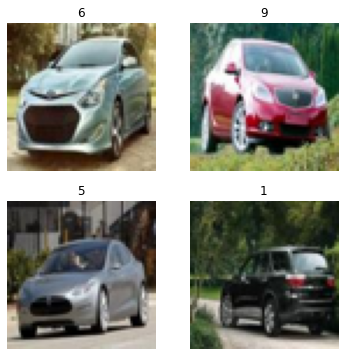

In [105]:
dls = get_dataloader()

# sanity check
dls.show_batch(cmap='gray')

## Conditional DDPM Training as a Callback

Same as DDPM callback but:
- We invert the x,y structure of the original callback
- Generates noise on the callback for the whole batch
- The sampling "before_batch_sampling" is done with labels that are fixed to [0,1,2,3,4...9,0,1,2,3....]

In [106]:
class ConditionalDDPMCallback(Callback):
    def __init__(self, n_steps, beta_min, beta_max, cfg_scale=0):
        store_attr()
        self.tensor_type=TensorImage

    def before_fit(self):
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps).to(self.dls.device) # variance schedule, linearly increased with timestep
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.sigma = torch.sqrt(self.beta)
    
    def sample_timesteps(self, x, dtype=torch.long):
        return torch.randint(self.n_steps, (x.shape[0],), device=x.device, dtype=dtype)
    
    def generate_noise(self, x):
        return self.tensor_type(torch.randn_like(x))
    
    def noise_image(self, x, eps, t):
        alpha_bar_t = self.alpha_bar[t][:, None, None, None]
        return torch.sqrt(alpha_bar_t)*x + torch.sqrt(1-alpha_bar_t)*eps # noisify the image
    
    def before_batch_training(self):
        x0 = self.xb[0] # original images and labels
        y0 =  self.yb[0] if np.random.random() > 0.1 else None
        
        # y0 = None
        
        eps = self.generate_noise(x0) # noise same shape as x0
        t = self.sample_timesteps(x0) # select random timesteps
        xt = self.noise_image(x0, eps, t)  # add noise to the image
        # print(x0.shape, y0.shape, t.shape, xt.shape, eps.shape)
        
        self.learn.xb = (xt, t, y0) # input to our model is noisy image, timestep and label
        self.learn.yb = (eps,) # ground truth is the noise 

    def sampling_algo(self, xt, t, label=None):
        t_batch = torch.full((xt.shape[0],), t, device=xt.device, dtype=torch.long)
        z = self.generate_noise(xt) if t > 0 else torch.zeros_like(xt)
        alpha_t = self.alpha[t] # get noise level at current timestep
        alpha_bar_t = self.alpha_bar[t]
        sigma_t = self.sigma[t]
        alpha_bar_t_1 = self.alpha_bar[t-1]  if t > 0 else torch.tensor(1, device=xt.device)
        beta_bar_t = 1 - alpha_bar_t
        beta_bar_t_1 = 1 - alpha_bar_t_1
        predicted_noise = self.model(xt, t_batch, label=label)
        if self.cfg_scale>0:
            uncond_predicted_noise = self.model(xt, t_batch, label=None)
            predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, self.cfg_scale)
        x0hat = (xt - torch.sqrt(beta_bar_t) * predicted_noise)/torch.sqrt(alpha_bar_t)
        x0hat = torch.clamp(x0hat, -1, 1)
        xt = x0hat * torch.sqrt(alpha_bar_t_1)*(1-alpha_t)/beta_bar_t + xt * torch.sqrt(alpha_t)*beta_bar_t_1/beta_bar_t + sigma_t*z 

        return xt
   
    def sample(self):            
        xt = self.generate_noise(self.xb[0])  # a full batch at once!
        label = torch.arange(10, dtype=torch.long, device=xt.device).repeat(xt.shape[0] // 10 + 1).flatten()[
                0:xt.shape[0]]
        for t in progress_bar(reversed(range(self.n_steps)), total=self.n_steps, leave=False):
            xt = self.sampling_algo(xt, t, label)
        return xt
    
    def before_batch_sampling(self):
        xt = self.sample()
        self.learn.pred = (xt,)
        raise CancelBatchException
    
    def after_validate(self):
        if (self.epoch+1) % 4 == 0:
            with torch.no_grad():
                xt = self.sample()
                wandb.log({"preds": [wandb.Image(torch.tensor(im)) for im in xt[0:36]]})
    
    def before_batch(self):
        if not hasattr(self, 'gather_preds'): self.before_batch_training()
        else: self.before_batch_sampling()
    
    def get_sample(self, input_dim, label, embedding=None):
        if embedding is None:
            embedding = self.tensor_type(torch.randn(input_dim))
        embedding = embedding.to(device)
        for t in progress_bar(reversed(range(self.n_steps)), total=self.n_steps, leave=False):
            images = self.sampling_algo(embedding, t, label)

        return images, embedding
    
    def save(self, filepath):
        state = {
            'n_steps': self.n_steps,
            'beta_min': self.beta_min,
            "beta": self.beta,
            'beta_max': self.beta_max,
            'cfg_scale': self.cfg_scale,
            'alpha': self.alpha,
            "alpha_bar": self.alpha_bar,
            "sigma": self.sigma,
        }
        torch.save(state, filepath)

    def load(self, filepath):
        if device.type == "cpu":
            state = torch.load(filepath, map_location=torch.device('cpu'))
        else:
            state = torch.load(filepath)
        self.n_steps = state['n_steps']
        self.beta_min = state['beta_min']
        self.beta_max = state['beta_max']
        self.cfg_scale = state['cfg_scale']
        self.alpha = state['alpha']
        self.alpha_bar = state["alpha_bar"]
        self.sigma = state["sigma"]
        self.beta = state["beta"]

In [107]:
class EMA(Callback):
    "Exponential Moving average CB"
    def __init__(self, beta=0.995, pct_start=0.3):
        store_attr()
        
    def before_fit(self):
        self.ema_model = deepcopy(self.model).eval().requires_grad_(False)
        self.step_start_ema = int(self.pct_start*self.n_epoch)  #start EMA at 30% of epochs
        
    def update_model_average(self):
        for current_params, ma_params in zip(self.model.parameters(), self.ema_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self):
        if self.epoch < self.step_start_ema:
            self.reset_parameters()
            self.step += 1
            return
        self.update_model_average()
        self.step += 1

    def reset_parameters(self):
        self.ema_model.load_state_dict(self.model.state_dict())
    
    def after_batch(self):
        if hasattr(self, 'pred'): return
        self.step_ema()
    
    def after_training(self):
        self.model = self.ema_model

We have to add the conditioning to the Unet, to do so, we just subclass it and inject the encoded label on the `forward` pass.

In [108]:
@delegates(Unet)
class ConditionalUnet(Unet):
    def __init__(self, dim, num_classes=None, **kwargs):
        super().__init__(dim=dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, dim * 4)
    
    def forward(self, x, time, label=None):
        x = self.init_conv(x)
        t = self.time_mlp(time)
        if label is not None:
            t += self.label_emb(label)
            
        return super().forward_blocks(x, t)

In [64]:
#import wandb
#from fastai.callback.wandb import WandbCallback

In [76]:
model = ConditionalUnet(dim=IMG_SIZE, channels=3, num_classes=10).to(device)
ddpm_learner = Learner(dls, model, 
                       cbs=[ConditionalDDPMCallback(n_steps=100, beta_min=0.0001, beta_max=0.02, cfg_scale=3), # n_steps = 1000!
                            EMA()], 
                       loss_func=nn.L1Loss())

Let's use fastai's amazing LR finder to select a good LR for training:

In [64]:
#ddpm_learner.lr_find()

And now let's train with one-cycle LR schedule:

In [65]:
# wandb.init(project="ddpm_fastai", group="cifar10", tags=["fp", "ema"])

In [10]:
# Check if GPU is detected
if torch.cuda.is_available():
    print("Using GPU!")

In [ ]:
# RUN TRAINING - WITHOUT WANDB
epochs = 1 # was 100

ddpm_learner.fit_one_cycle(epochs, 3e-4)

In [ ]:
# RUN TRAINING
#ddpm_learner.fit_one_cycle(epochs, 3e-4, cbs=[SaveModelCallback(monitor="train_loss", fname="cifar10"), 
#                                               WandbCallback(log_preds=False, log_model=True)])

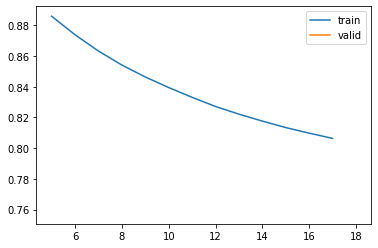

In [97]:
ddpm_learner.recorder.plot_loss()

## Save stuff

In [66]:
learner_name = "learner_v1"
callback_name = "callback_v1"

In [29]:
# Save the entire Learner, including model and callbacks
ddpm_learner.save(learner_name)  # For some reason this can only save to models/
# cf https://github.com/fastai/fastai/blob/master/fastai/learner.py#L405
# and https://github.com/fastai/fastcore/blob/master/fastcore/xtras.py#L438

callback = ddpm_learner.conditional_ddpm
callback.save(f'output/{callback_name}.pth')

### CHECKPOINT - LOAD

In [109]:
# Create a new instance of the ConditionalDDPMCallback and load its state
loaded_callback = ConditionalDDPMCallback(n_steps=0, beta_min=0, beta_max=0, cfg_scale=0)
loaded_callback.load(f'output/{callback_name}.pth')

# Load the Learner from the saved file
ddpm_learner = Learner(dls, model, 
                       cbs=[loaded_callback,
                            EMA()],
                       loss_func=nn.L1Loss())

ddpm_learner.load(learner_name, device=None, with_opt=True, strict=True)

# Replace the original callback with the loaded one
#loaded_learner.cbs = [loaded_callback, EMA()]

## Sample generation

### Try via get_sample (FAULTY)

In [40]:
nr_images = 1
class_label = 2
pred_image, embedding = ddpm_learner.conditional_ddpm.get_sample((nr_images, 3, 32, 32), torch.tensor(class_label).to(device))#, embedding=embedding)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


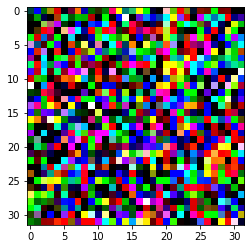

In [41]:
# plot prediction
img_nr = 0
plt.imshow(pred_image[img_nr].permute(1,2,0).detach().numpy())
plt.show()

### Predictions via get_preds (WORKING)

In [110]:
# This prob goes through the whole validation set
preds = ddpm_learner.get_preds()

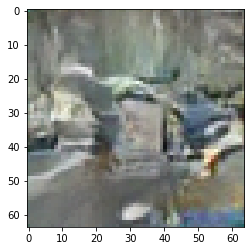

In [130]:
# Plot prediction
img_nr = 11
img = preds[0][img_nr]
img = (img*0.5)+0.5
plt.imshow(img.permute(1,2,0).detach().numpy())
plt.show()

## Experimental

In [ ]:
# get five predictions per class
nr_images = 5
preds = {}
for c in [1,5,9]:
    preds[c] = ddpm_learner.conditional_ddpm.get_sample((nr_images, 3, 32, 32), torch.tensor(c).to(device))

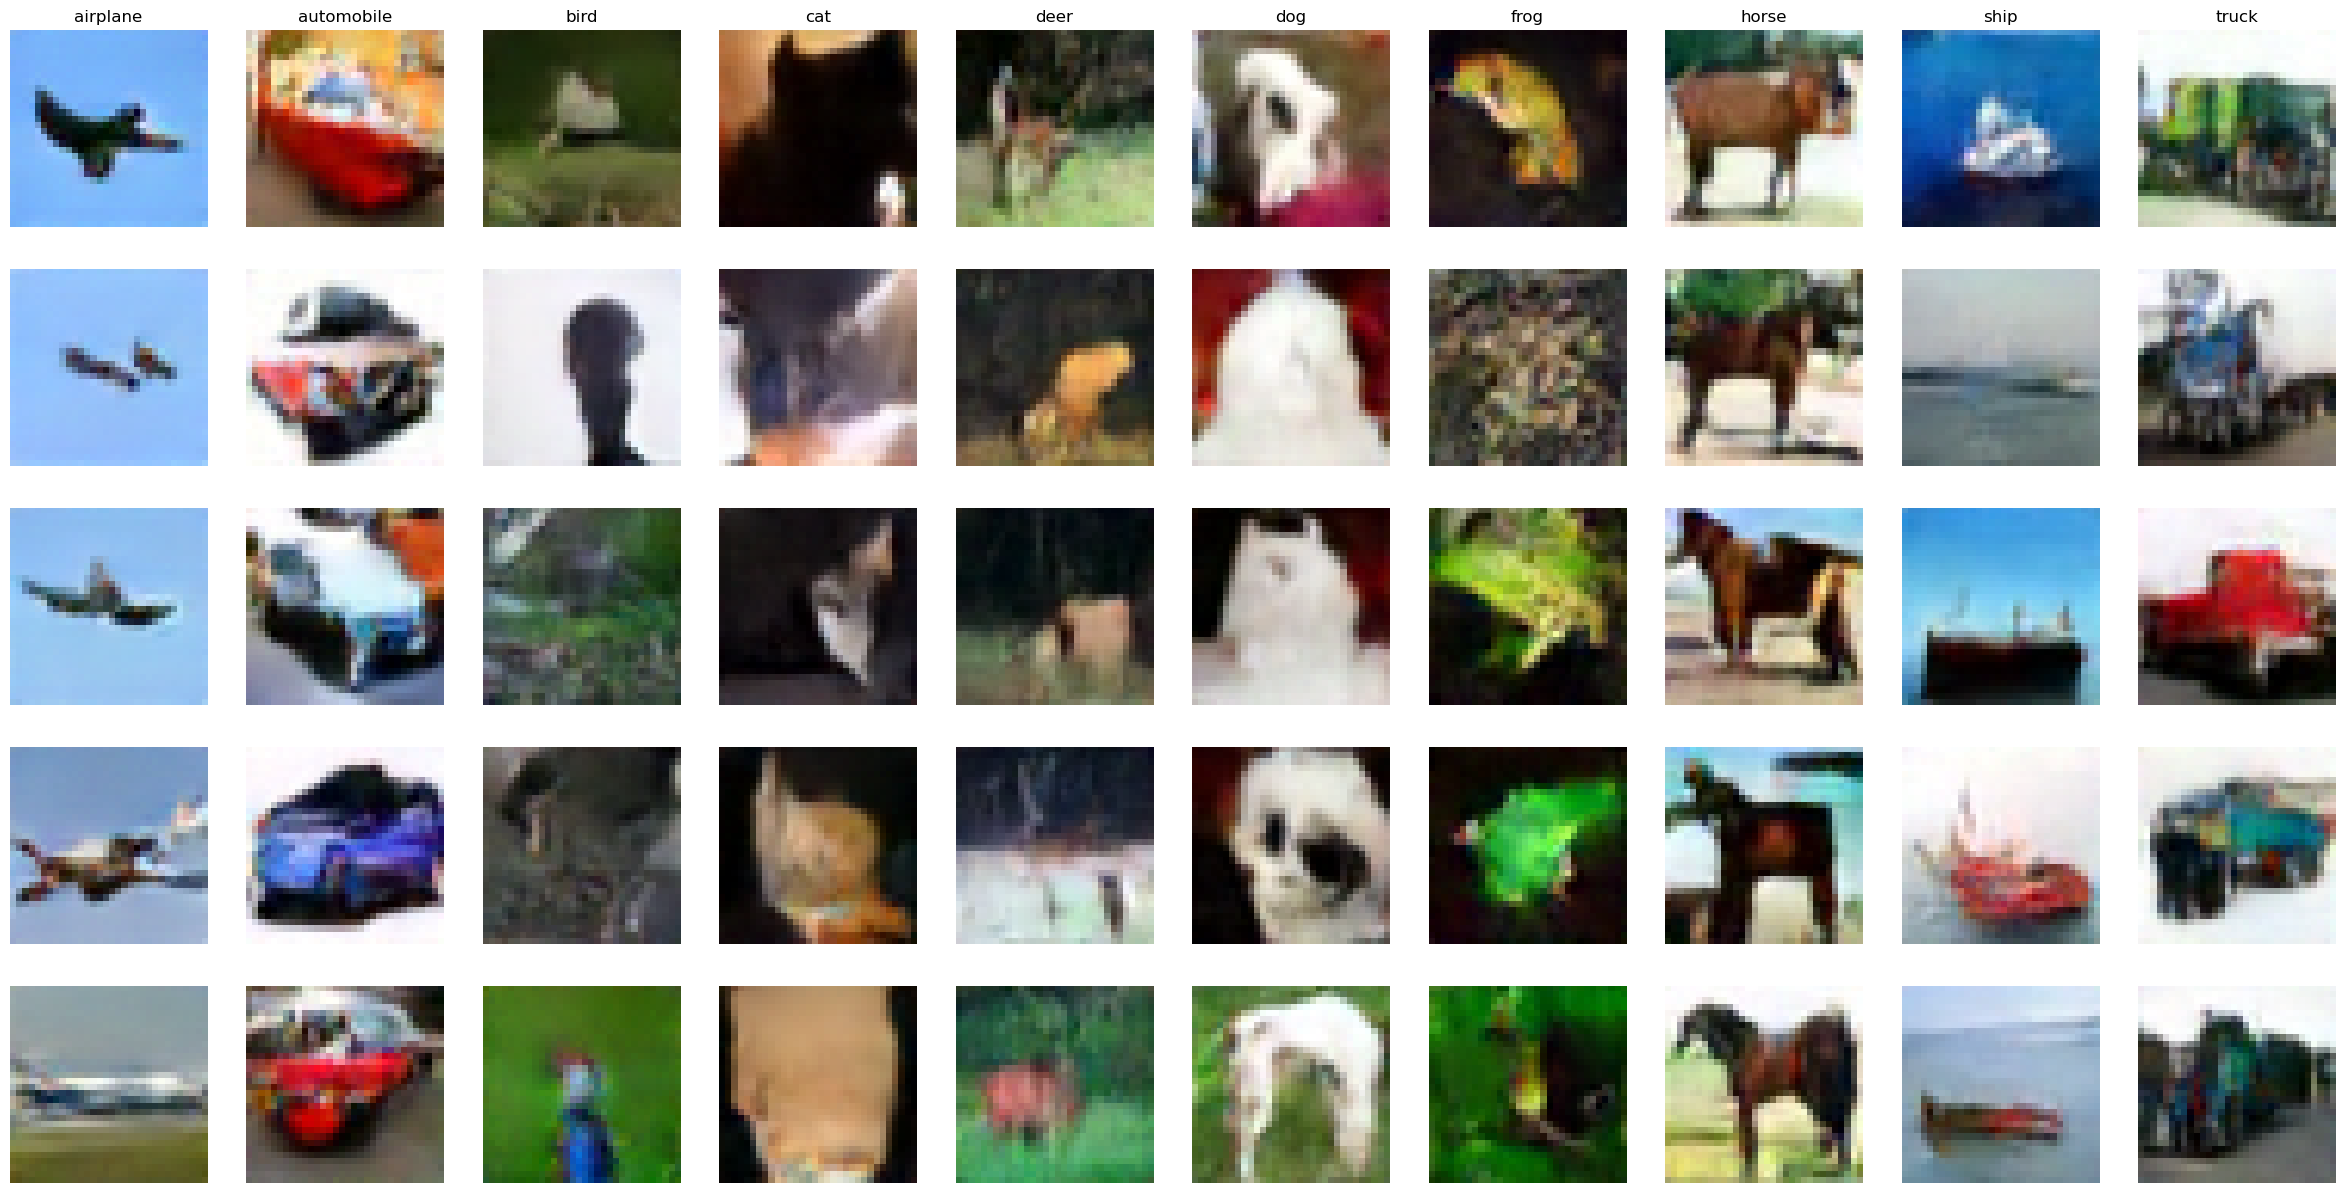

In [27]:
nrows=5
ncols = int(math.ceil(25/10))
axs = subplots(nrows, 10)[1].flat
for i, (pred, ax) in enumerate(zip(preds[0], axs)): 
    ((pred+1)/2).show(ax=ax, title=i)